# Housing Prices Competition: Preprocessing and Predictions 🏘️💰📈

<br>

<img src="https://images.unsplash.com/photo-1508404140693-f3a1a3e2a85d?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1338&q=80" width = 600>
<center>Photo by Annie Spratt (Unsplash)</center>

<br>

**Table of Contents**

- [Overview](#Overview)
- [Libraries and Default Parameters](#Libraries-and-Default-Parameters)
- [Getting the Data](#Getting-the-Data)
- [Data Preprocessing](#Data-Preprocessing)
    - [Missing Values](#Missing-Values) <br>
    - [Label Encoding and Factorizing Variables](#Label-Encoding-and-Factorizing-Variables) <br>
    - [Dealing with Outliers](#Dealing-with-Outliers) <br>
    - [Feature Engineering](#Feature-Engineering) <br>
    - [Feature Selection](#Feature-Selection) <br>
    - [One-hot Encoding](#One-hot-Encoding) <br>
    - [Scaling](#Scaling)
- [Building Machine Learning Models](#Building-Machine-Learning-Models)
    - [Baseline Models](#Baseline-Models) <br>
    - [Model Tuning](#Model-Tuning) <br>
    - [Comparison](#Comparison) <br>
    - [Feature Importance](#Feature-Importance)
- [Test Set](#Test-Set)
- [Submission](#Submission)
- [References](#References)
- [Conclusions](#Conclusions)


<br>

# Overview



<br>

# Libraries and Default Parameters

We start by importing the necessary libraries and setting some parameters for the whole notebook. We will mainly use three Python libraries:

- Pandas for handling and analysing data,
- Seaborn and Matplotlib for data visualisation, and
- Scikit-learn for building Machine Learning models.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('precision', 2)

%config InlineBackend.figure_format = 'retina'  # Enable retina display

plt.style.use('fivethirtyeight')
main_color = '#B7C3F3'
edgecolor = 'black'
facecolor = '#f0f0f0'

font_size = 14

plt.rcParams['axes.edgecolor'] = '0.15'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2

plt.rcParams['lines.linewidth'] = 3

random_state = 42
scoring = 'neg_mean_absolute_error'

<br>

# Getting the Data

We will use the `read_csv()` method to load the two datasets we created in the first notebook. 

In [3]:
train_df = pd.read_csv('Datasets/train_new.csv')
test_df = pd.read_csv('Datasets/test_new.csv')

print('DataFrames loaded successfully!\n')
print('The train set contains {} rows and {} columns'.format(train_df.shape[0], train_df.shape[1]))
print(' The test set contains {} rows and {} columns'.format(test_df.shape[0], test_df.shape[1]))

DataFrames loaded successfully!

The train set contains 1460 rows and 80 columns
 The test set contains 1459 rows and 79 columns


We are going to **merge** the two DataFrames into one. The new dataframe will have NaN in the 'SalePrice' column for instances of the test set:

In [4]:
all_data = pd.concat([train_df, test_df]).reset_index(drop=True)

print('The combined dataset has {} rows and {} columns'.format(all_data.shape[0], all_data.shape[1]))
print("Number of NaN values in 'SalePrice': ",all_data['SalePrice'].isnull().sum())

The combined dataset has 2919 rows and 80 columns
Number of NaN values in 'SalePrice':  1459


<br> 

# Data Preprocessing

<br>

## Missing Values

We have already dealt with missing values in the first notebook. We can check that there are indeed no missing values in the new datasets.

In [5]:
X = all_data[all_data.columns.difference(['SalePrice'])]

no_features = (X.isnull().sum(axis=0) != 0).sum()
print('There are {} features with missing values.'.format(no_features))

There are 0 features with missing values.


<br>

## Label Encoding and Factorising Variables

The dataset contains several categorical features, which we need to somehow encode to numbers before building any ML model. For ordinal features specifically, we need to encode them in a way that two nearby values are more similar than two distant values. 

For instance, there are ten categorical features related to condition or quality. After reading the descriptions.txt file, we note that they have the same categories/labels:

| Label 	|     Meaning     	|
|:-----:	|:---------------:	|
|   Ex  	|    Excellent    	|
|   Gd  	|       Good      	|
|   TA  	| Typical/Average 	|
|   Fa  	|       Fair      	|
|   Po  	|       Poor      	|
|  None 	|    No Garage    	|

We would ideally like our model to assume that 'Excellent' is similar/close to 'Good' but distant from 'Poor'. We can achieve this in two steps:

1) We define a dictionary that maps labels to numbers in a way that preserves the ordering, and <br>
2) Call the `replace()` function the column and pass the dictionary as the only argument.

In [6]:
condition_dict = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

for column in [
        'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
        'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'
]:

    all_data[column] = all_data[column].replace(condition_dict)

We can repeat this process for all other ordinal features. For example, 'LotShape' describes the general shape of a property and can take only four values:

| Label 	|        Meaning       	|
|:-----:	|:--------------------:	|
|  Reg  	|        Regular       	|
|  IR1  	|  Slightly irregular  	|
|  IR2  	| Moderately Irregular 	|
|  IR3  	|       Irregular      	|

It appears there is some ordinality since a regular shape is in theory more desired thatn an irregular one.

In [7]:
lot_shape_dict = {'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3}
all_data['LotShape'] = all_data['LotShape'].replace(lot_shape_dict)

Let's take a closer look at the masonry veneer type ('MasVnrType'):

In [8]:
gb = train_df.groupby(['MasVnrType'])
counts = gb.size().to_frame(name='Count')

counts.join(train_df.groupby('MasVnrType')['SalePrice'].median()).sort_values(by='SalePrice')

,Count,SalePrice
MasVnrType,,
BrkCmn,15,139000.0
None,872,143125.0
BrkFace,445,181000.0
Stone,128,246839.0


As []() pointed out, there seems to be a significant difference between "common brick/none" and the other types of masonry. We can assume that there is indeed ordinality in this variable.

In [9]:
all_data['MasVnrType'] = all_data['MasVnrType'].replace({'None':0, 'BrkCmn':0, 'BrkFace':1, 'Stone':2})

We will not go into details about the rest of the features that need encoding.

In [10]:
all_data['GarageFinish'] = all_data['GarageFinish'].replace({'None':0, 'Unf':1, 'RFn':2, 'Fin':3})
all_data['BsmtExposure'] = all_data['BsmtExposure'].replace({'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4})

for col in ['BsmtFinType1', 'BsmtFinType2']:
    all_data[col] = all_data[col].replace({'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
    
all_data['Functional'] = all_data['Functional'].replace({'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7})
all_data['LandSlope'] = all_data['LandSlope'].map({'Sev':0, 'Mod':1, 'Gtl':2})
all_data['PavedDrive'] = all_data['PavedDrive'].map({'N':0, 'P':1, 'Y':2})

Finally, we can use the same technique to encode binary features.

In [11]:
all_data['CentralAir'] = all_data['CentralAir'].map({'N': 0, 'Y': 1})
all_data['Street'] = all_data['Street'].map({'Grvl': 0, 'Pave': 1})

<br>

## Dealing with Outliers

The [documentation](http://jse.amstat.org/v19n3/decock.pdf) for the Ames Housing Data states that there are outliers present in the training set and suggests we plot 'SalePrice' against 'GrLivArea' (i.e. 'Above ground living area square feet') to see them:

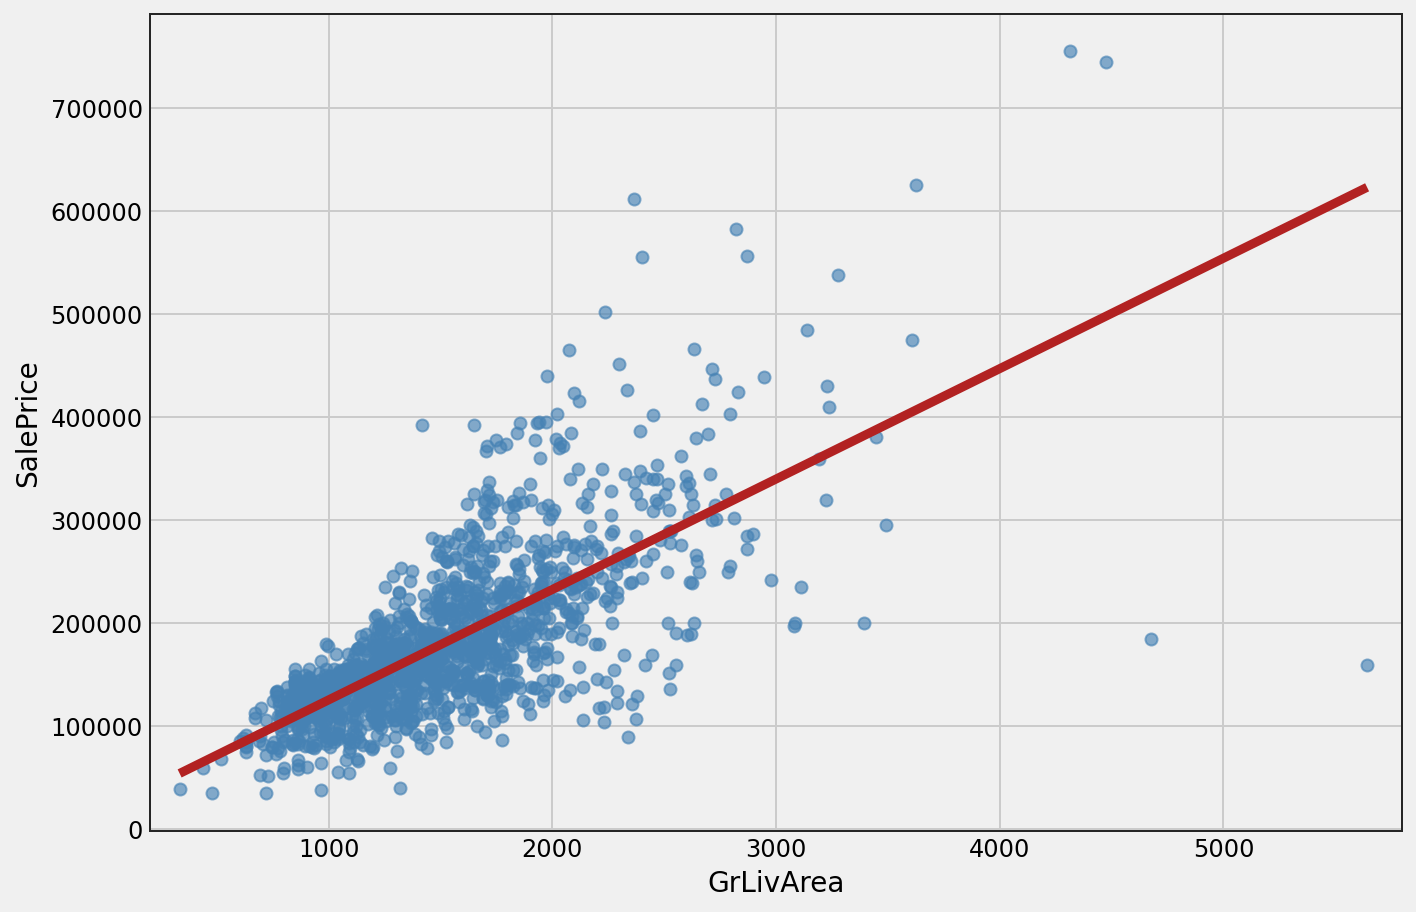

In [12]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.regplot(x='GrLivArea',
            y='SalePrice',
            data=train_df,
            ci=None,
            color='steelblue',
            scatter_kws={'alpha': 0.65},
            line_kws={'color': 'firebrick'},
            ax=ax)

ax.set_xlim([200, 5800]);

The two points at the lower right part of the plot (extremely large area for a low price) could be classified as outliers. We will follow the documentation and remove points 'more than 4,000 square feet from the data set'. By doing that, we can increase the correlation of 'GrLivArea' with 'SalePrice'.

In [13]:
corr_before = train_df[['GrLivArea', 'SalePrice']].corr().loc['GrLivArea', 'SalePrice']

outliers_idx = train_df[train_df['GrLivArea'] > 4_000].index
all_data_outliers = all_data.drop(outliers_idx)

corr_after = all_data_outliers[['GrLivArea', 'SalePrice']].corr().loc['GrLivArea',  'SalePrice']

print('Correlation')
print('Before: ', np.round(corr_before, 3))
print(' After: ', np.round(corr_after, 3))

Correlation
Before:  0.709
 After:  0.721


However, 'GrLivArea' is not the only feature with outliers. The box plots in the first notebook helped us identify  features with extreme outliers. As a reminder, we will visualise the boxplots again, but only for the features we will treat:

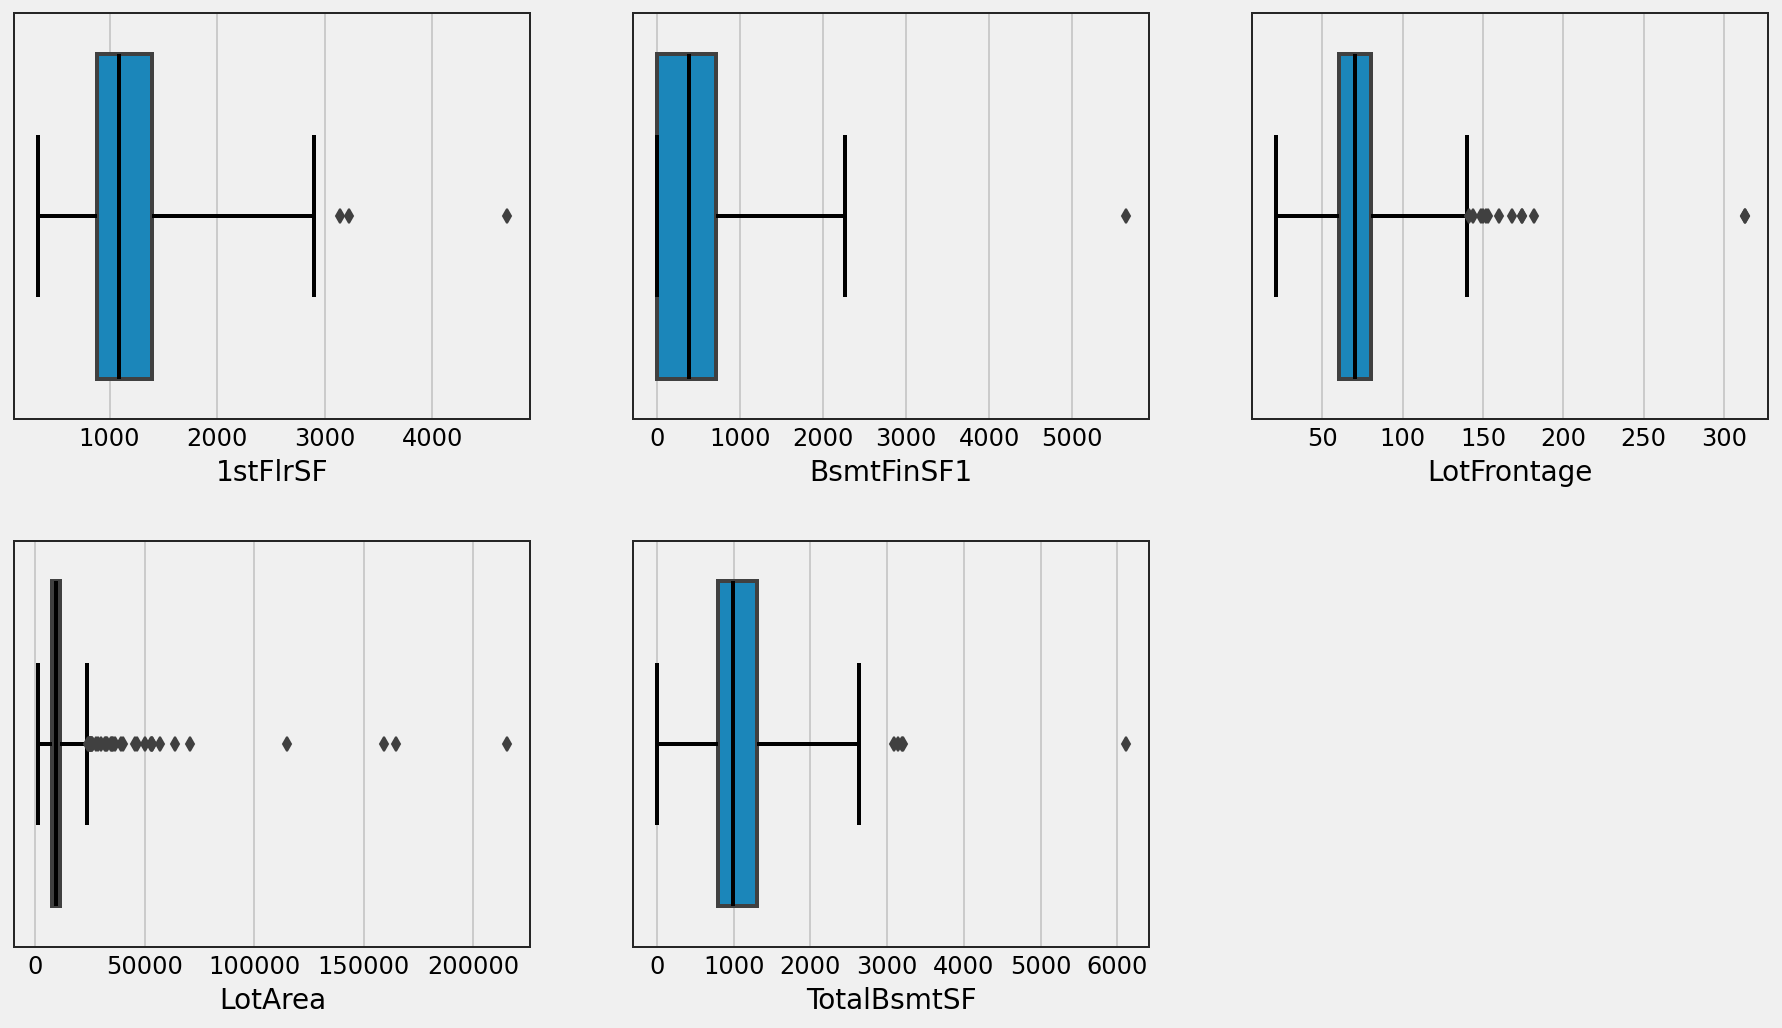

In [14]:
out_col = ['1stFlrSF', 'BsmtFinSF1', 'LotFrontage', 'LotArea', 'TotalBsmtSF']

fig = plt.figure(figsize=(14, 8), facecolor='#f0f0f0')

for index, col in enumerate(out_col):

    plt.subplot(2, 3, index + 1)
    sns.boxplot(
        x=col,
        data=train_df,
        whis=3,
        linewidth=2,
        medianprops={'color': edgecolor},
        capprops={'color': edgecolor},
        whiskerprops={'color': edgecolor},
    )

plt.subplots_adjust(hspace=0.3);

For each one, we will remove the outliers based on a certain threshold value.

In [15]:
idx_drop = []
idx_drop.extend(train_df[train_df['GrLivArea'] > 4_000].index)
idx_drop.extend(train_df[train_df['1stFlrSF'] > 3_000].index)
idx_drop.extend(train_df[train_df['BsmtFinSF1'] > 4_000].index)
idx_drop.extend(train_df[train_df['LotFrontage'] > 200].index)
idx_drop.extend(train_df[train_df['LotArea'] > 100_000].index)
idx_drop.extend(train_df[train_df['TotalBsmtSF'] > 5_000].index)

idx_drop = list(set(idx_drop))

all_data = all_data.drop(idx_drop)
all_data.reset_index(drop = True);

In [16]:
# numeric_atts = all_data.select_dtypes(exclude=['object'])
# cat_atts = all_data.select_dtypes(include=['object'])

# correlations = numeric_atts.select_dtypes(exclude=['object']).corr()
# correlations = correlations[['SalePrice']].sort_values(by=['SalePrice'],
#                                                        ascending=False)
# indeces = correlations.iloc[:17].index
# corr_matrix = numeric_atts.select_dtypes(exclude=['object']).corr().loc[indeces, indeces]

# plt.figure(figsize=(15, 13))

# sns.heatmap(corr_matrix, annot=True, mask=np.triu(corr_matrix), linewidth=1, cmap='Reds');

<br>

## Feature Engineering

Feature Engineering is the process of using domain knowledge to create useful new features from the existing ones. This process aims to improve the predictive performance of the new models.



<br>

### Total Number of Bathrooms

The first feature we will create is 'TotalBath', which combines the four individual features realted to bathrooms. I followed []()'s suggestion and assigned a smaller weigth (0.5) to features related to half bathrooms.

Correlation with 'SalePrice':

   TotalBath: 0.63

Individual Features
   FullBath: 0.56
   BsmtFullBath: 0.23
   HalfBath: 0.29
   BsmtHalfBath: -0.04


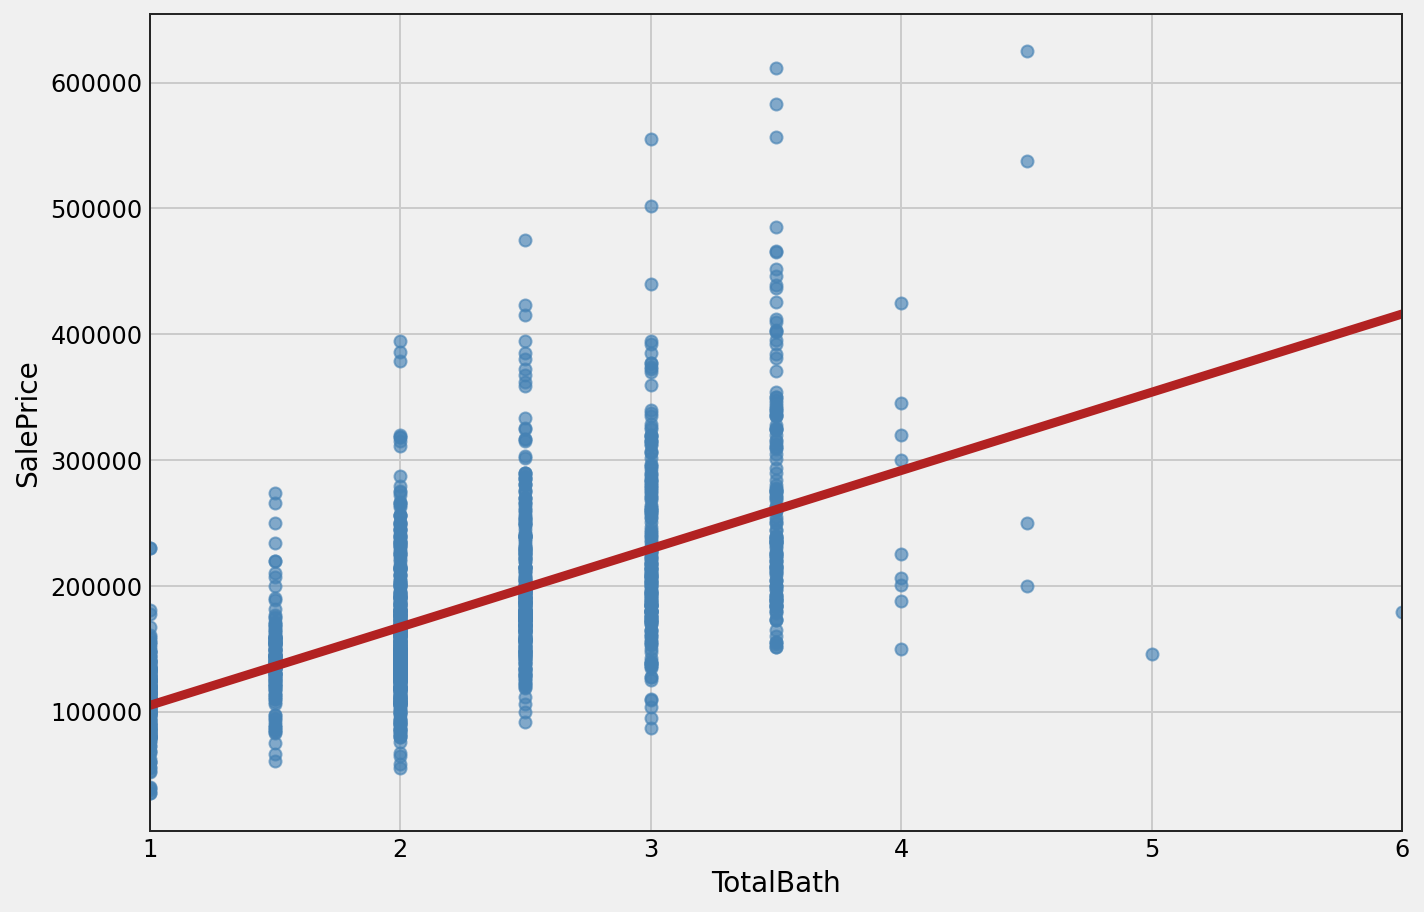

In [17]:
all_data['TotalBath'] = all_data['FullBath'] + all_data['BsmtFullBath'] + 0.5 * all_data['HalfBath'] + 0.5 * all_data['BsmtHalfBath']

print("Correlation with 'SalePrice':\n")

cor = all_data[['TotalBath', 'SalePrice']].corr().loc['TotalBath', 'SalePrice']
print('   ' + 'TotalBath' + ': ' + str(np.round(cor, 2)))

print("\nIndividual Features")
for col in ['FullBath', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath']:
    cor = all_data[[col, 'SalePrice']].corr().loc[col, 'SalePrice']
    print('   ' + col + ': ' + str(np.round(cor, 2)))

fig, ax = plt.subplots(figsize=(10, 7))

sns.regplot(x='TotalBath',
            y='SalePrice',
            data=all_data,
            ci=None,
            color='steelblue',
            scatter_kws={'alpha': 0.65},
            line_kws={'color': 'firebrick'},
            ax=ax);

<br>

### Binning Neighborhood



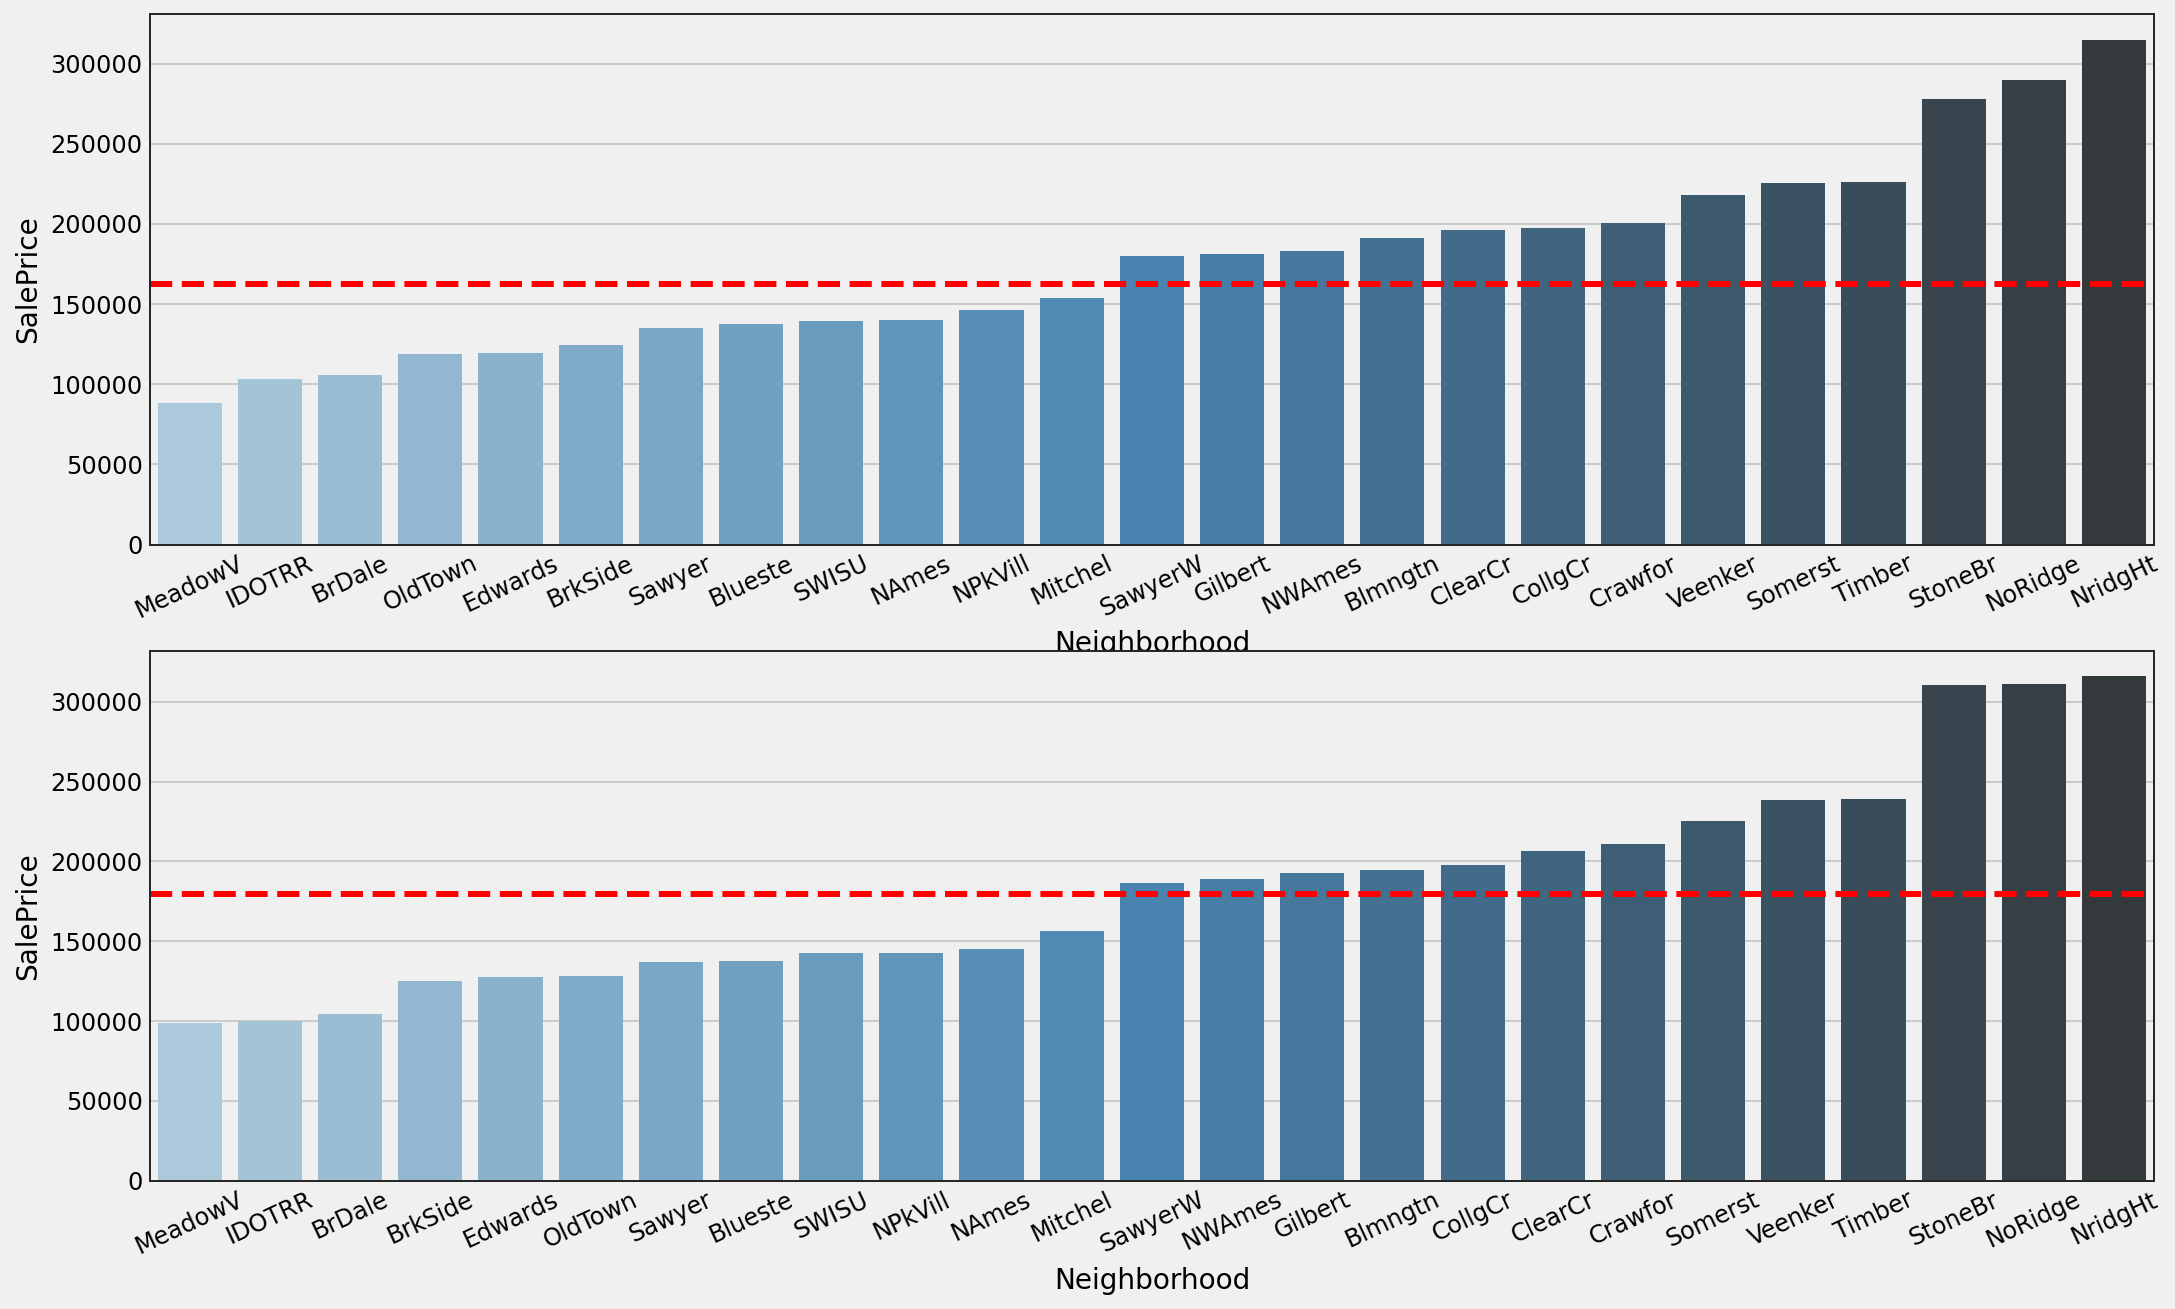

In [18]:
neighbour_median = all_data.groupby('Neighborhood')['SalePrice'].median()
neighbour_median = neighbour_median.to_frame().sort_values(by='SalePrice',
                                                           ascending=True)

neighbour_mean = all_data.groupby('Neighborhood')['SalePrice'].mean()
neighbour_mean = neighbour_mean.to_frame().sort_values(by='SalePrice',
                                                           ascending=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

sns.barplot(x=neighbour_median.index,
            y=neighbour_median['SalePrice'],
            palette='Blues_d',
            ax=ax1)

sns.barplot(x=neighbour_mean.index,
            y=neighbour_mean['SalePrice'],
            palette='Blues_d',
            ax=ax2)

ax1.axhline(y=all_data['SalePrice'].median(), color = 'red', ls ='--')
ax2.axhline(y=all_data['SalePrice'].mean(), color = 'red', ls ='--')

ax.set_ylabel('Median SalePrice')
ax.set_ylabel('Mean SalePrice')

for ax in [ax1, ax2]:
    ax.tick_params(axis='x', rotation=25);

In [19]:
neighbour_median

,SalePrice
Neighborhood,
MeadowV,88000.0
IDOTRR,103000.0
BrDale,106000.0
OldTown,119000.0
Edwards,119500.0
BrkSide,124300.0
Sawyer,135000.0
Blueste,137500.0
SWISU,139500.0


In [20]:
def label_neighborhoods(row):
    if row in ['StoneBr', 'NridgHt', 'NoRidge']:
        return 2
    elif row in ['MeadowV', 'IDOTRR', 'BrDale']:
        return 0
    else:
        return 1

# def label_neighborhoods(row):
#     if row in ['StoneBr', 'NridgHt', 'NoRidge']:
#         return 3
#     if row in ['Timber', 'Somerst', 'Veenker', 'Crawfor', 'CollgCr', 'ClearCr', 'Blmngtn', 'NWAmes', 'Gilbert', 'SawyerW']:
#         return 2
#     elif row in ['MeadowV', 'IDOTRR', 'BrDale']:
#         return 0
#     else:
#         return 1


all_data['Neigh_Rich'] = all_data['Neighborhood'].apply(lambda row: label_neighborhoods(row))
all_data['Neigh_Rich'].value_counts()

1    2464
2     285
0     160
Name: Neigh_Rich, dtype: int64

In [21]:
train_df['Neigh_Rich'] = train_df['Neighborhood'].apply(lambda row: label_neighborhoods(row))
gb = train_df.groupby(['Neigh_Rich'])
counts = gb.size().to_frame(name='Count')

counts.join(train_df.groupby('Neigh_Rich')['SalePrice'].median()).sort_values(by='SalePrice')

,Count,SalePrice
Neigh_Rich,,
0,70,100500.0
1,1247,159000.0
2,143,306000.0


<br>

### Total Square Feet

Finally, we will combine features 'GrLivArea' and 'TotalBsmtSF' into a single one, 'TotalSqFeet'. The new feature adds up the living space above and below ground.

Correlation with 'SalePrice':

   TotalSqFeet: 0.82

Individual Features
   GrLivArea: 0.72
   TotalBsmtSF: 0.64


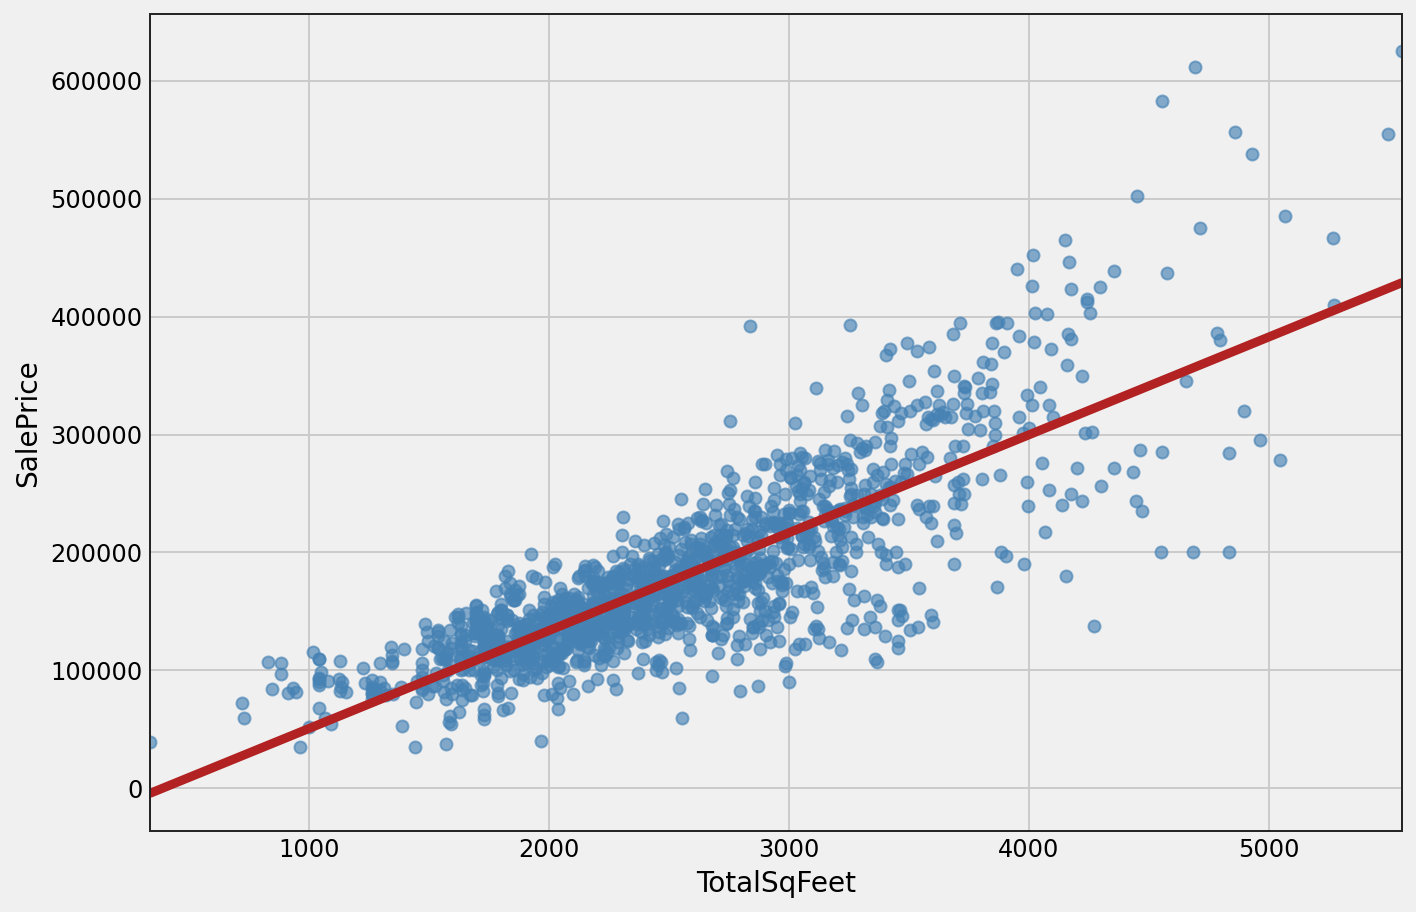

In [22]:
all_data['TotalSqFeet'] = all_data['GrLivArea'] + all_data['TotalBsmtSF']

print("Correlation with 'SalePrice':\n")

cor = all_data[['TotalSqFeet', 'SalePrice']].corr().loc['TotalSqFeet', 'SalePrice']
print('   ' + 'TotalSqFeet' + ': ' + str(np.round(cor, 2)))

print("\nIndividual Features")
for col in ['GrLivArea', 'TotalBsmtSF']:
    cor = all_data[[col, 'SalePrice']].corr().loc[col, 'SalePrice']
    print('   ' + col + ': ' + str(np.round(cor, 2)))

fig, ax = plt.subplots(figsize=(10, 7))

sns.regplot(x='TotalSqFeet',
            y='SalePrice',
            data=all_data,
            ci=None,
            color='steelblue',
            scatter_kws={'alpha': 0.65},
            line_kws={'color': 'firebrick'},
            ax=ax);

<br>

## Feature Selection

### Dropping Highly Correlated Variables

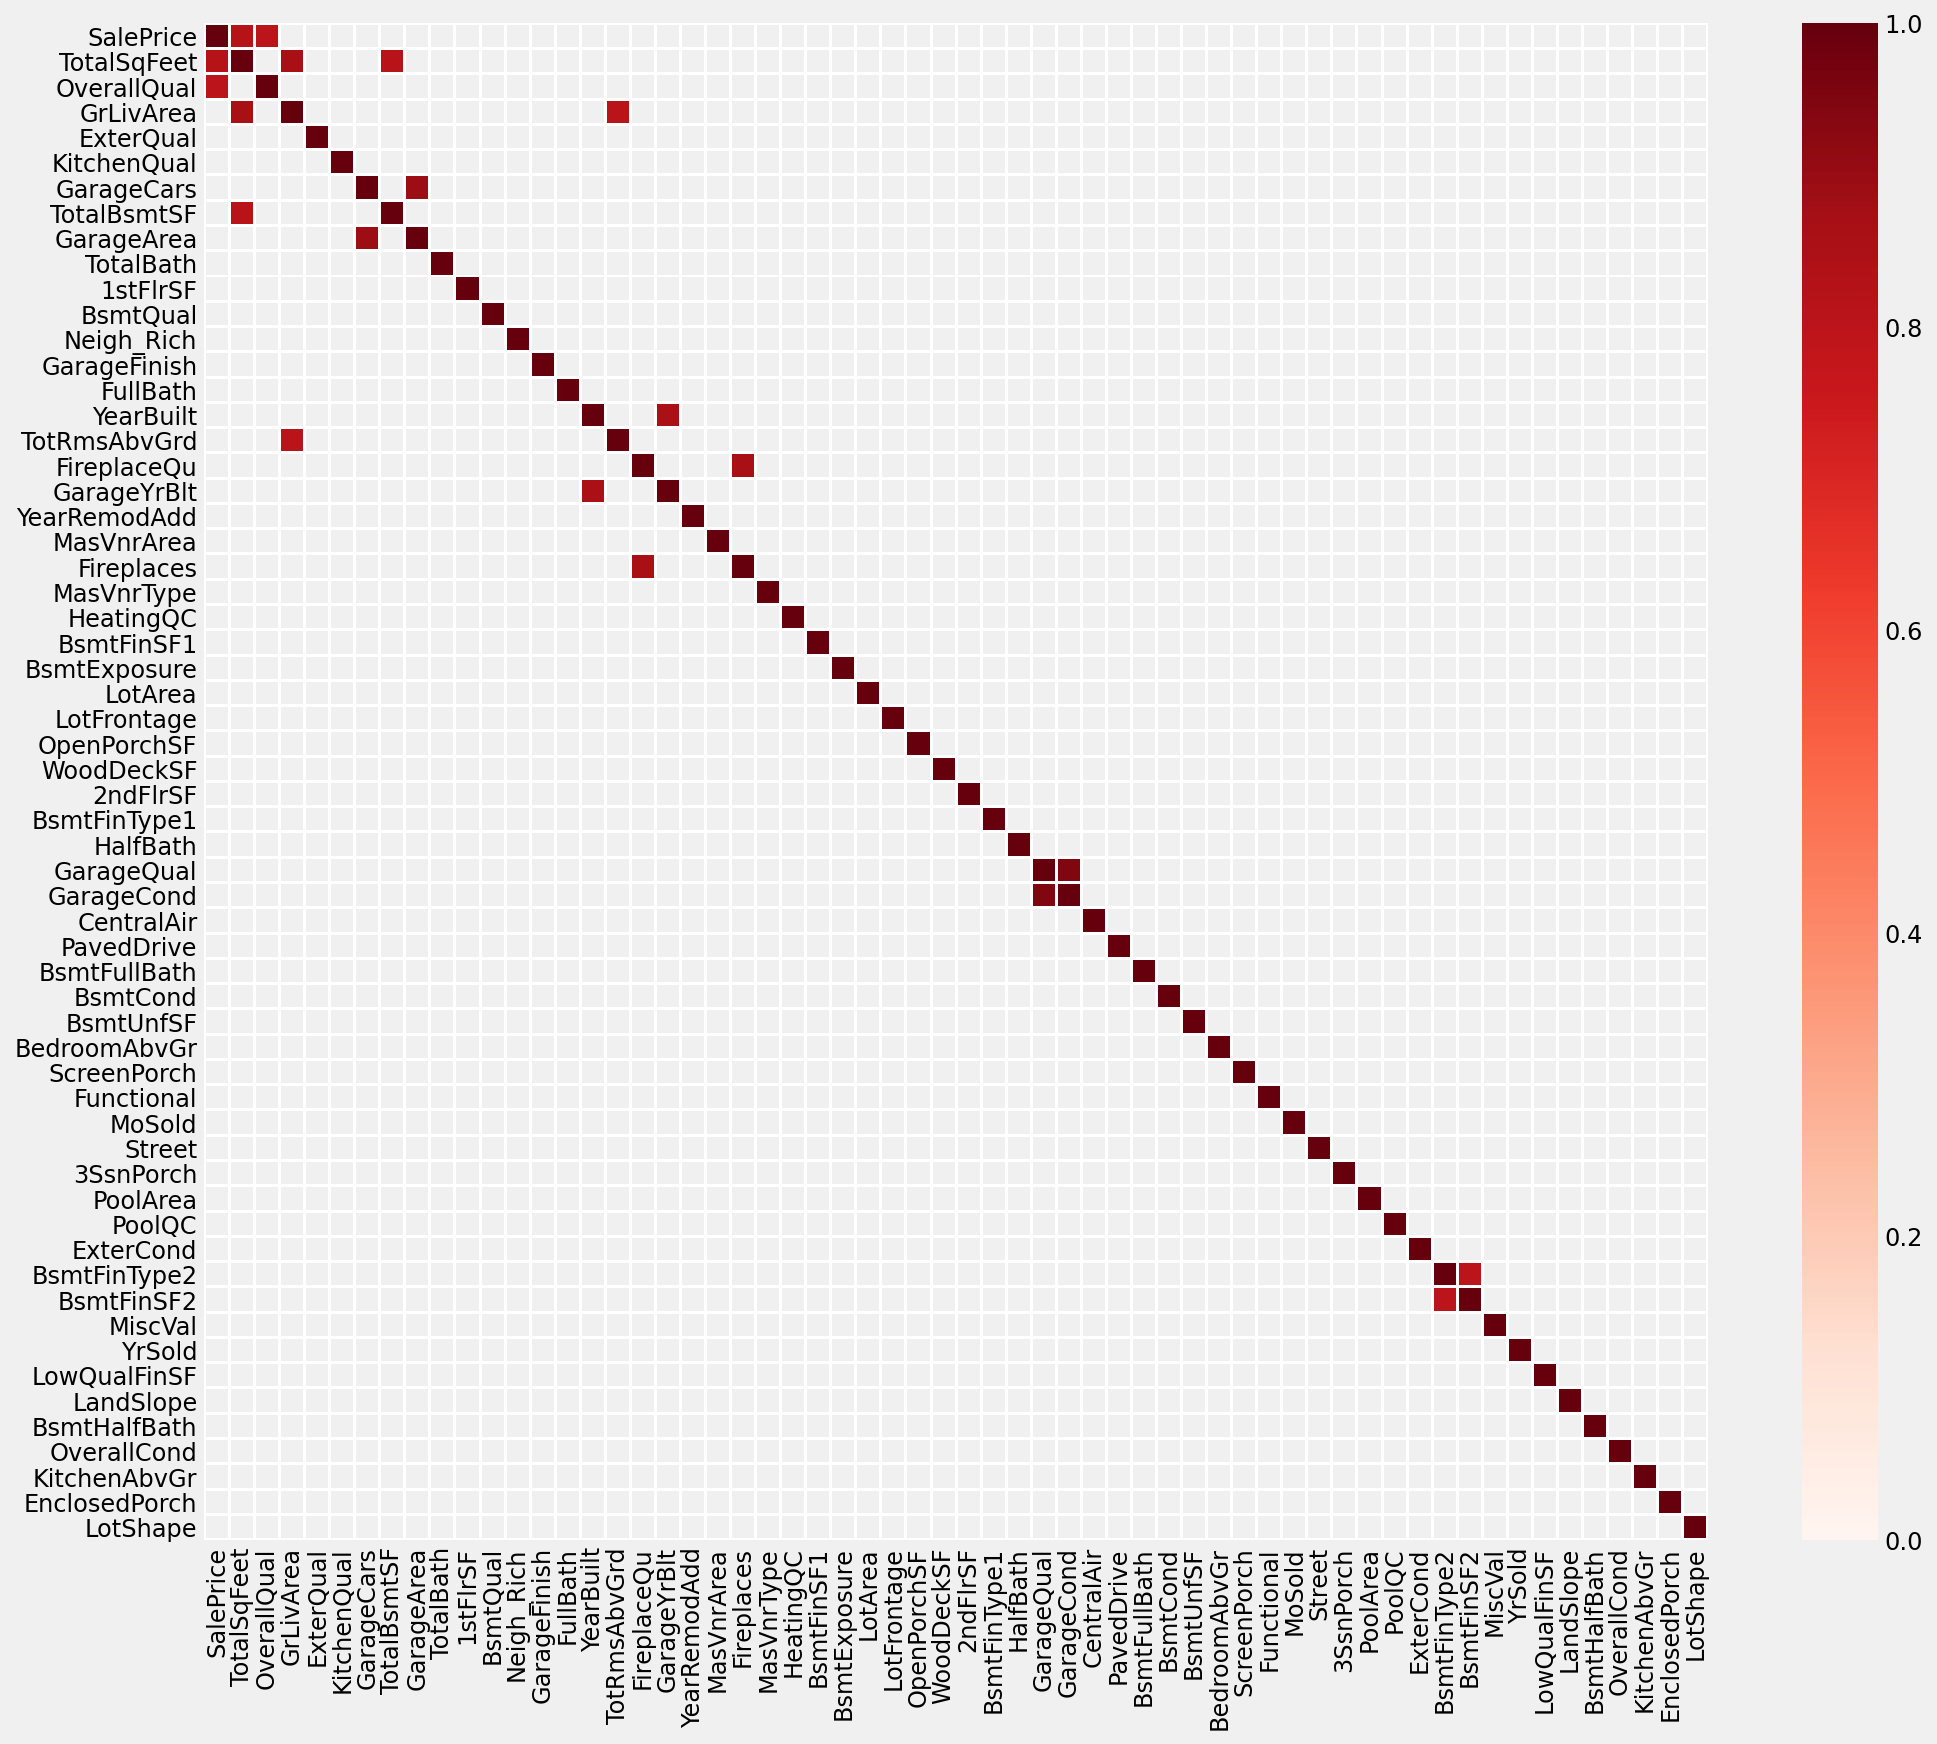

In [23]:
numeric_atts = all_data.select_dtypes(exclude=['object'])
correlations = numeric_atts.corr()
correlations = correlations[['SalePrice']].sort_values(by=['SalePrice'],
                                                       ascending=False)
indeces = correlations.index

corr_matrix = numeric_atts.corr().loc[indeces, indeces]
matrix = np.triu(corr_matrix)

plt.figure(figsize=(15, 13))

sns.heatmap(corr_matrix, mask=corr_matrix < 0.80, vmin=0, linewidth=1, cmap='Reds');

In [24]:
cols_drop = ['GrLivArea', 'TotalBsmtSF', 'GarageArea', 'GarageYrBlt', 'Fireplaces', 'GarageCond']
all_data.drop(cols_drop, axis=1, inplace=True)

### Droppin Features with Low Variance

In [25]:
thd = 0.95
cols_drop = []

for column in all_data.drop('SalePrice', axis=1):

    most_freq_value = all_data[column].value_counts(normalize=True).iloc[0]
    if (most_freq_value > thd):
        cols_drop.append(column)
        print('{}: {}% same value'.format(column, np.round(most_freq_value, 3)))

all_data.drop(cols_drop, axis=1, inplace=True)
print('\nFeatures with low variance dropped successfully!')

Street: 0.996% same value
Utilities: 1.0% same value
LandSlope: 0.953% same value
Condition2: 0.99% same value
RoofMatl: 0.986% same value
Heating: 0.985% same value
LowQualFinSF: 0.986% same value
KitchenAbvGr: 0.954% same value
3SsnPorch: 0.987% same value
PoolArea: 0.996% same value
PoolQC: 0.997% same value
MiscFeature: 0.965% same value
MiscVal: 0.965% same value

Features with low variance dropped successfully!


<br>

## 

In [26]:
categorical = all_data.select_dtypes(include=['object']).columns
numeric = all_data.select_dtypes(exclude=['object']).columns

ordinal = [
    'FireplaceQu', 'GarageQual', 'BsmtQual', 'BsmtCond', 'KitchenQual',
    'ExterQual', 'ExterCond', 'HeatingQC', 'LotShape', 'GarageFinish',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'Functional',
    'CentralAir', 'PavedDrive', 'OverallCond', 'OverallQual', 'BsmtFullBath',
    'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd',
    'GarageCars', 'TotalBath', 'Neigh_Rich'
]

binary = ['CentralAir']

continuous = [
    col for col in all_data.select_dtypes(exclude=['object'])
    if col not in (ordinal or binary)
]

continuous.remove('SalePrice')

In [27]:
print('Number of Categorical columns: ', len(categorical))
print('Number of Numeric columns: ', len(numeric))
print(' - Ordinal: ', len(ordinal))
print(' - Binary: ', len(binary))
print(' - Continuous: ', len(continuous))

Number of Categorical columns:  18
Number of Numeric columns:  46
 - Ordinal:  28
 - Binary:  1
 - Continuous:  17


<br>

## One-hot Encoding

In [28]:
all_data_before = all_data.copy()

all_data = pd.get_dummies(all_data, columns=categorical, drop_first=True)
print('One-hot encoding completed!\n')
print('Shape before: ', all_data_before.shape)
print(' Shape after: ', all_data.shape)

One-hot encoding completed!

Shape before:  (2909, 64)
 Shape after:  (2909, 183)


<br>

## Splitting Back into Training/Test Sets

Lastly, we need to split the combined dataset back into train and test set:

In [29]:
idx = all_data['SalePrice'].notnull().sum()

# Training Set
train_df = all_data[:idx]

X_train = train_df.drop('SalePrice', 1)
y_train = train_df['SalePrice']
y_train = np.log1p(y_train)

# Test Set
test_df = all_data[idx:]

X_test = test_df.copy()
X_test.drop('SalePrice', axis = 1, inplace = True)

print ('Splitting: Done!')

Splitting: Done!


In [30]:
# X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
# X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [31]:
X_train_full = X_train.copy()
y_train_full = y_train.copy()

X_test_original = X_test.copy()

X_test_temp = X_train.iloc[1250:]
y_test_temp = y_train.iloc[1250:]

X_train = X_train.iloc[:1250]
y_train = y_train.iloc[:1250]

<br>

## Dealing with Skewness of Response Variable

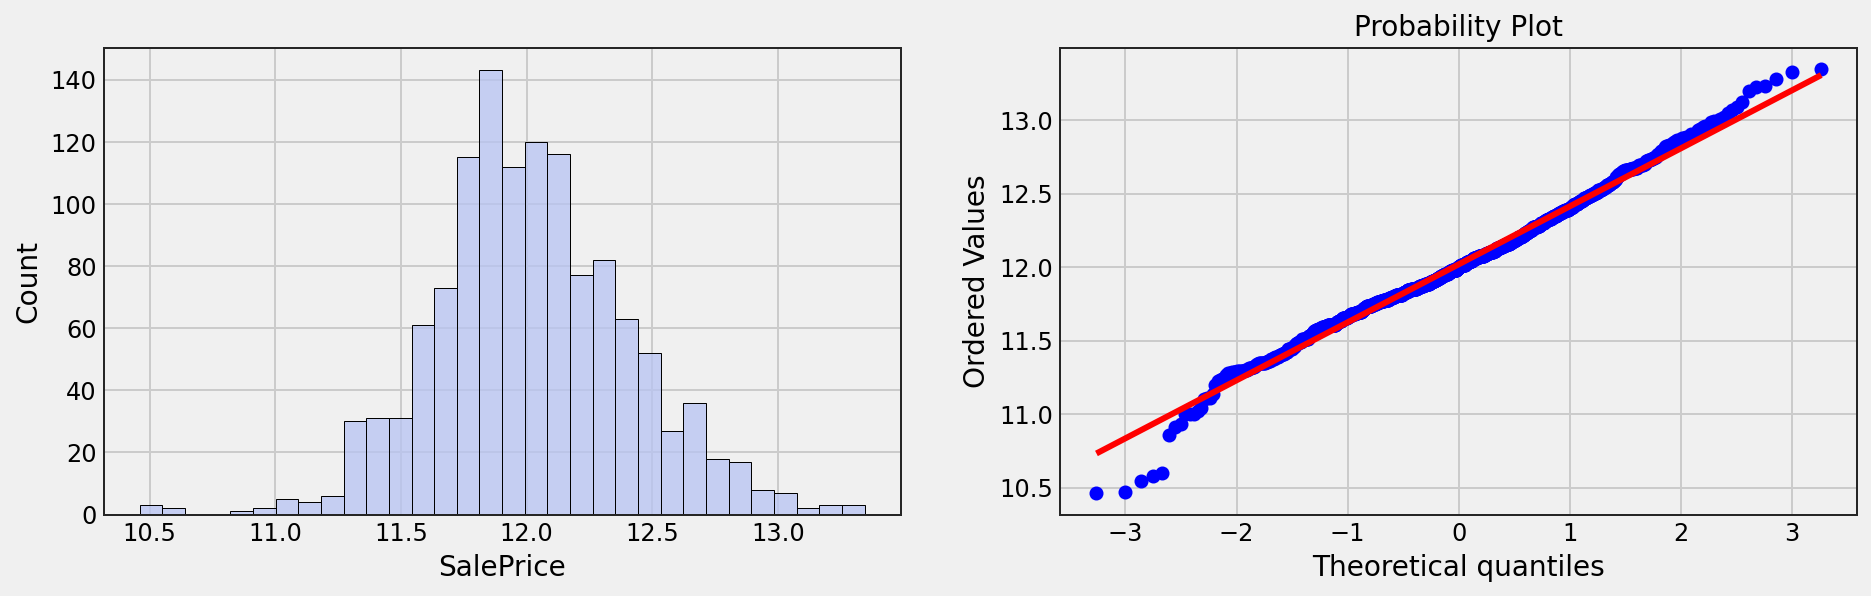

In [32]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), facecolor=facecolor)

sns.histplot(y_train,
             color=main_color,
             edgecolor=edgecolor,
             ax=ax1)

res = stats.probplot(y_train, plot=ax2)

<br>

## Scaling

In [33]:
scaler = StandardScaler()
scaler.fit(X_train[continuous])

X_train[continuous] = scaler.transform(X_train[continuous])
X_test[continuous] = scaler.transform(X_test[continuous])
X_test_temp[continuous] = scaler.transform(X_test_temp[continuous])

<br>

# Building Machine Learning Models

<br>

## Baseline Models

In [34]:
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [35]:
y_pred = np.full(len(y_train), y_train.mean())
mae_base_mean = mean_absolute_error(y_train, y_pred)
print('  Mean: ', np.round(mae_base_mean, 4))

y_pred = np.full(len(y_train), y_train.median())
mae_base_median = mean_absolute_error(y_train, y_pred)
print('Median: ', np.round(mae_base_median, 4))

  Mean:  0.3071
Median:  0.3067


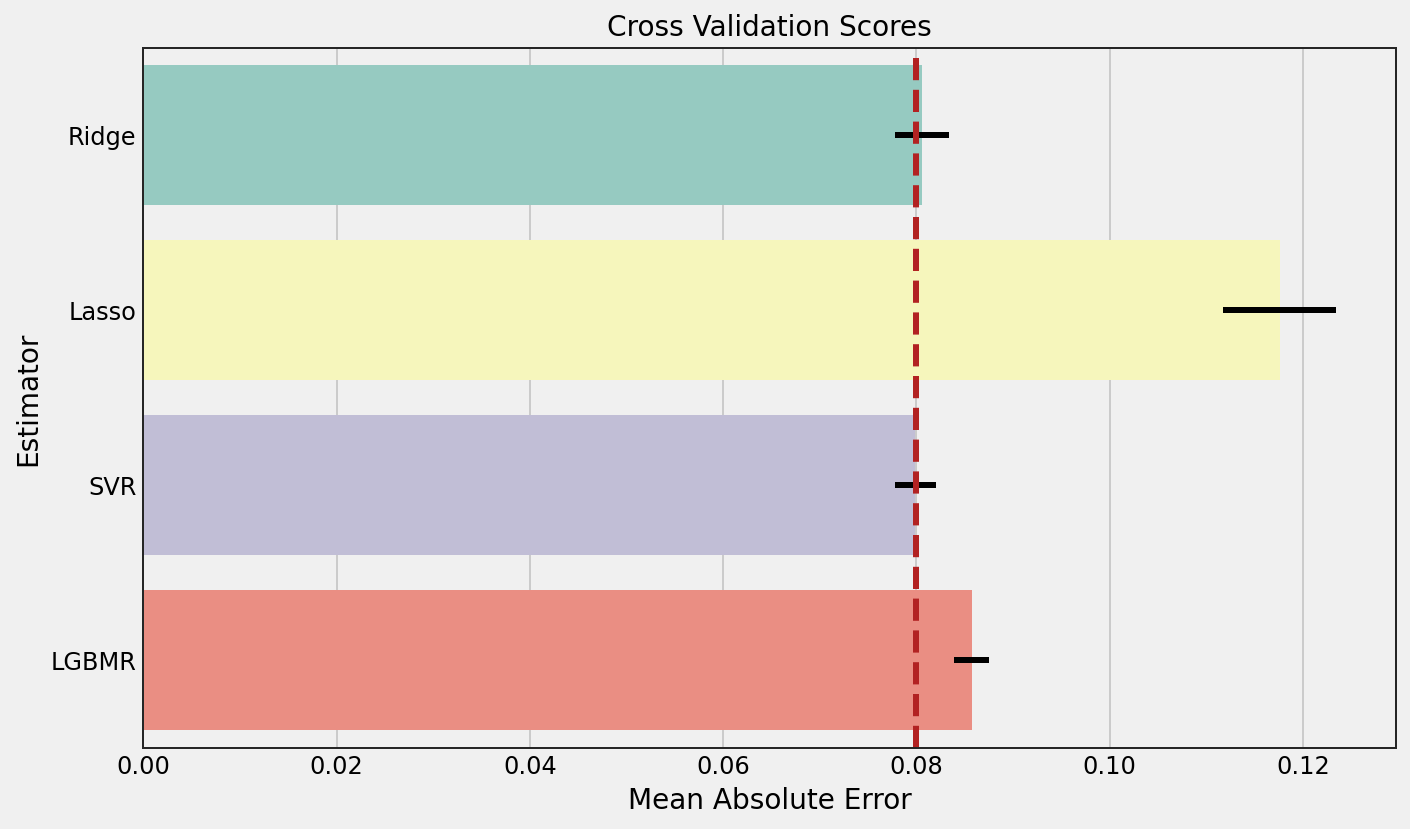

In [36]:
# Step 1: create a list containing all estimators with their default parameters
names = ['Ridge', 'Lasso', 'SVR', 'LGBMR']

estimators = [
    Ridge(random_state=random_state),
    Lasso(0.05, random_state=random_state),
    SVR(),
    LGBMRegressor(verbose=-1, random_state=random_state)
]

# Step 2: calculate the cv mean and standard deviation for each one of them
cv_base_mean, cv_std = [], []
for est in estimators:

    cv = cross_val_score(est,
                         X_train,
                         y_train,
                         scoring=scoring,
                         cv=5,
                         n_jobs=-1)
    cv_base_mean.append(-cv.mean())
    cv_std.append(cv.std())

# Step 3: create a dataframe and plot the mean with error bars
cv_baseline = pd.DataFrame({
    'Estimator': names,
    'CV-Means': cv_base_mean,
    'CV-Errors': cv_std
})

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(x='CV-Means',
            y='Estimator',
            data=cv_baseline,
            palette='Set3',
            orient='h',
            **{'xerr': cv_std},
            ax=ax)

ax.set_xlabel('Mean Absolute Error')
ax.set_title('Cross Validation Scores')
ax.axvline(x=0.08, color='firebrick', linestyle='--');

In [37]:
pd.set_option('precision', 5)
cv_baseline

,Estimator,CV-Means,CV-Errors
0,Ridge,0.08055,0.00280
1,Lasso,0.11760,0.00588
2,SVR,0.07990,0.00212
3,LGBMR,0.08572,0.00182


In [38]:
cv_tuned = {}

def Model_Performance(model_name, model):

    print(model_name)
    print('-----------------------------------------')
    print('        Best Score: ', str(-model.best_score_))
    print('   Best Parameters: ', str(model.best_params_))

    arg_min = np.argmin(model.cv_results_['rank_test_score'])
    scores_list = []
    for i in [
            'split0_test_score', 'split1_test_score', 'split2_test_score',
            'split3_test_score', 'split4_test_score'
    ]:
        scores_list.append(-model.cv_results_[i][arg_min])

    cv_tuned[model_name] = scores_list

print('Function ready!')

Function ready!


<br>

## Model Tuning

### Ridge

In [39]:
ridge = Ridge(random_state=random_state)

param_grid = {'alpha': [0.001, 0.1, 1, 10, 100, 1000]}

ridge_grid = GridSearchCV(ridge,
                          param_grid=param_grid,
                          cv=5,
                          scoring=scoring,
                          verbose=True,
                          n_jobs=-1)
best_grid_ridge = ridge_grid.fit(X_train, y_train)

Model_Performance('Ridge', best_grid_ridge)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ridge
-----------------------------------------
        Best Score:  0.07905511040528397
   Best Parameters:  {'alpha': 10}


### Lasso

In [40]:
ls = Lasso(random_state=random_state)

param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

ls_grid = GridSearchCV(ls,
                       param_grid=param_grid,
                       cv=5,
                       scoring=scoring,
                       verbose=True,
                       n_jobs=-1)
best_grid_ls = ls_grid.fit(X_train, y_train)

Model_Performance('Lasso', best_grid_ls)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Lasso
-----------------------------------------
        Best Score:  0.07930810225916704
   Best Parameters:  {'alpha': 0.001}


### SVR

In [41]:
svr = SVR()

param_grid = {
    'kernel': ['rbf'],
#     'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'],
    'coef0': [0, 1, 10],
    'C': [0.001, 0.1, 1, 10],
    'epsilon': [0.001, 0.01, 0.1, 1]
}

svr_grid = GridSearchCV(svr,
                        param_grid=param_grid,
                        cv=5,
                        scoring=scoring,
                        verbose=True,
                        n_jobs=-1)
best_grid_svr = svr_grid.fit(X_train, y_train)

Model_Performance('SVR', best_grid_svr)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
SVR
-----------------------------------------
        Best Score:  0.0737975218591589
   Best Parameters:  {'C': 1, 'coef0': 0, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}


### LGBMRegressor

In [42]:
lgbm = LGBMRegressor(verbose=-1, random_state=random_state)
param_grid = {
    'boosting_type': ['gbdt'],
    'n_estimators': [50, 100, 1000],
    'num_leaves': [31],
    'max_depth': [5, 10, 50],
    'learning_rate': [0.001, 0.01, 0.1],
    'feature_fraction': [0.4, 0.6, 0.8],
    'min_data_in_leaf': [5, 10, 20],
}

grid_lgbm = GridSearchCV(lgbm,
                         param_grid,
                         cv=5,
                         scoring=scoring,
                         verbose=True,
                         n_jobs=-1)

best_grid_lgbm = grid_lgbm.fit(X_train, y_train)

Model_Performance('LGBMRegressor', best_grid_lgbm)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
LGBMRegressor
-----------------------------------------
        Best Score:  0.0783956364135143
   Best Parameters:  {'boosting_type': 'gbdt', 'feature_fraction': 0.4, 'learning_rate': 0.01, 'max_depth': 10, 'min_data_in_leaf': 20, 'n_estimators': 1000, 'num_leaves': 31}


<br>

## Comparison

In [43]:
pd.set_option('precision', 5)

In [44]:
cv_tuned_mean = [np.mean(list(cv_tuned.items())[i][1]) for i in range(len(cv_tuned))]

cv_total = pd.DataFrame({
    'Algorithm': names,
    'Baseline': cv_base_mean,
    'Tuned Performance': cv_tuned_mean
})

cv_total.style.highlight_min(color='lightskyblue', axis=1)

,Algorithm,Baseline,Tuned Performance
0,Ridge,0.08055,0.07906
1,Lasso,0.11760,0.07931
2,SVR,0.07990,0.07380
3,LGBMR,0.08572,0.07840


In [45]:
colors = ['#7798AB', '#4D5061', '#FFA987', '#724E91', '#C297B8', '#FE4A49']
model_names = [list(cv_tuned.items())[i][0] for i in range(len(cv_tuned))]
scores = [list(cv_tuned.items())[i][1] for i in range(len(cv_tuned))]
score_medians = [np.round(np.median(list(cv_tuned.items())[i][1]), 4) for i in range(len(cv_tuned))]

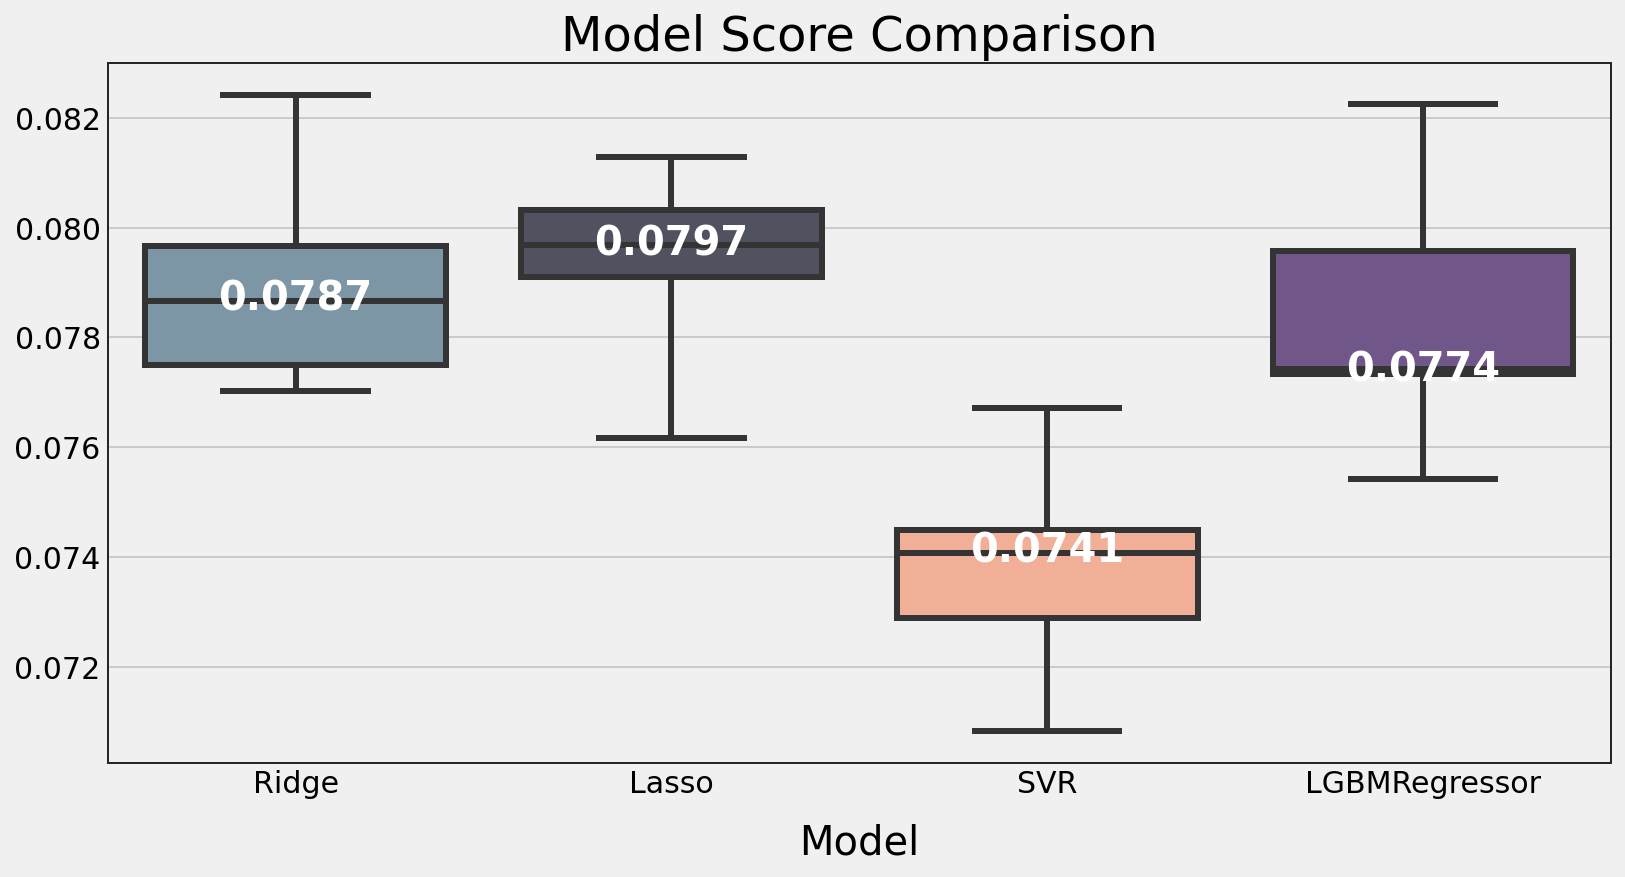

In [46]:
fig, ax = plt.subplots(figsize = (12, 6))

ax.set_title('Model Score Comparison', size = 24)
sns.boxplot(data = pd.DataFrame(cv_tuned), whis=5, palette = colors, ax = ax)

for xtick in ax.get_xticks():
    ax.text(xtick, score_medians[xtick] - 0.0002, score_medians[xtick],
            horizontalalignment = 'center', size = 20, color = 'w', weight = 'bold')
    
plt.xlabel('Model', size = 20, labelpad = 12)
plt.tick_params(axis = 'both', labelsize = 15);

<br>

## Feature Importance

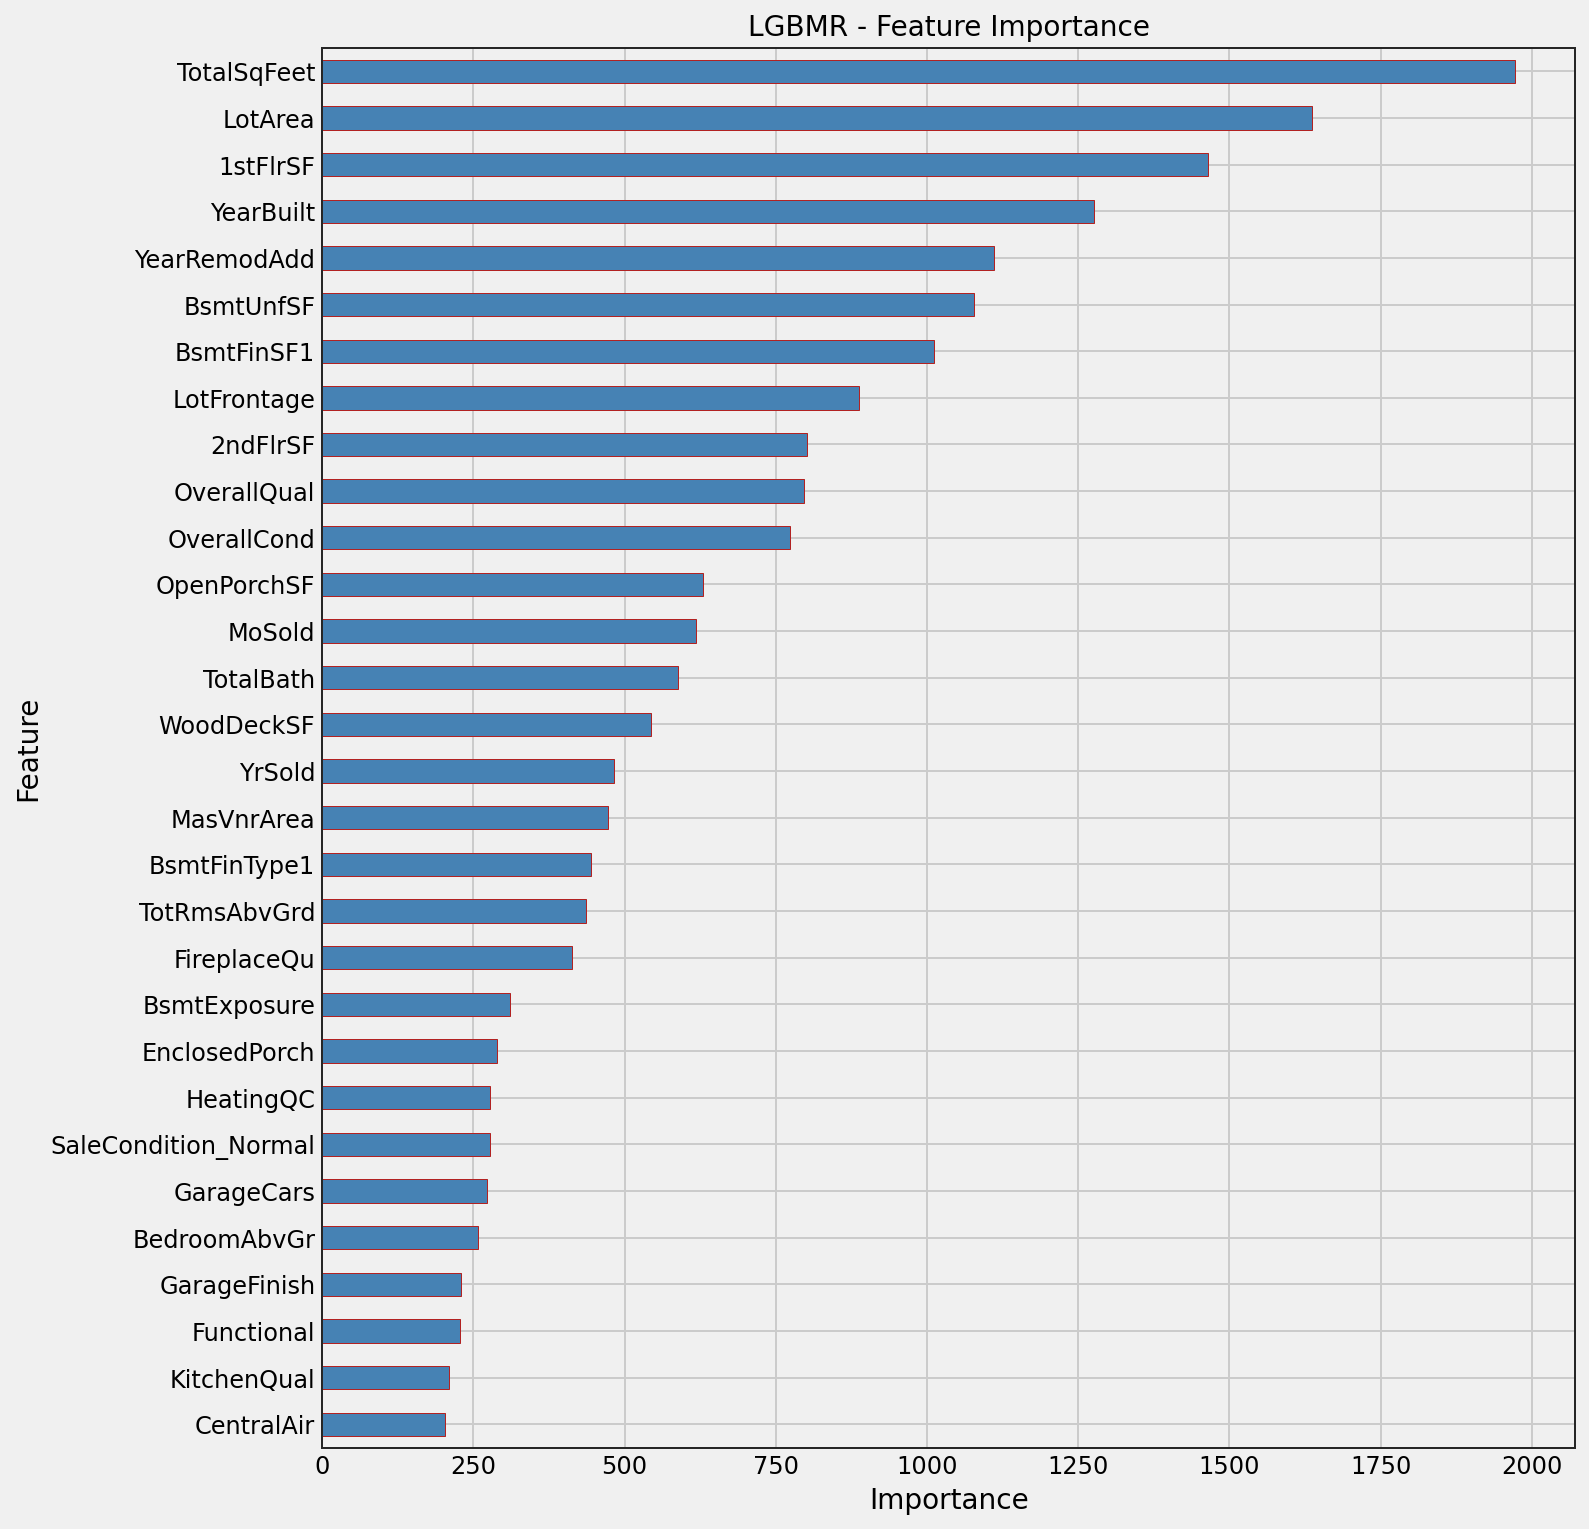

In [47]:
est = best_grid_lgbm.best_estimator_
n_features_vis = 30

feat_imp = pd.DataFrame({'Feature': X_train.columns,
                         'Importance': np.round(est.feature_importances_, 4)})

feat_imp = feat_imp.sort_values('Importance', ascending=False).set_index('Feature')
feat_imp = feat_imp.head(n_features_vis).iloc[::-1]

fig, ax = plt.subplots(figsize=(10, 12))

feat_imp.plot.barh(color='steelblue',
                   edgecolor='firebrick',
                   legend=False,
                   ax=ax)

ax.set(title='LGBMR - Feature Importance', xlabel='Importance');

<br>

# Test Set

In [48]:
best_estimators = [
    best_grid_ridge.best_estimator_, best_grid_ls.best_estimator_,
    best_grid_svr.best_estimator_, best_grid_lgbm.best_estimator_
]

for i, est in enumerate(best_estimators):
    est.fit(X_train, y_train)
    y_pred = est.predict(X_test_temp)
    
    mae_test = mean_absolute_error(y_test_temp, y_pred)
    
    print('{} - {}: {}'.format(i, names[i], np.round(mae_test, 3)))

0 - Ridge: 0.081
1 - Lasso: 0.081
2 - SVR: 0.075
3 - LGBMR: 0.08


In [49]:
for i, est in enumerate(best_estimators):
    est.fit(X_train, y_train)
    y_pred = est.predict(X_test_temp)
    
    mae_test = mean_absolute_error(np.expm1(y_test_temp), np.expm1(y_pred))
    
    print('{} - {}: {}'.format(i, names[i], np.round(mae_test, 3)))

0 - Ridge: 13945.14
1 - Lasso: 14060.991
2 - SVR: 12963.976
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
3 - LGBMR: 13870.342


<br>

# Submission

In [50]:
# for i in range(len(best_estimators)):
#     est = best_estimators[i]
    
#     est.fit(X_train_full, y_train_full)

#     sub_df = pd.read_csv('sample_submission.csv')

#     y_pred = est.predict(X_test_full)
#     y_pred_trans = np.expm1(y_pred)

#     sub_df['SalePrice'] = y_pred_trans
#     sub_df.to_csv('20102021-{}.csv'.format(names[i]), index = False)

<br>

# References

<br>

# Conclusions